## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz    
**Important:** Before proceeding, the student must reorganize the downloaded dataset files to match the expected directory structure, so that there is a dedicated folder for each class under 'test' and 'train', e.g.:

```
* test/airplane/airplane-1001.png
* test/bird/bird-1043.png

* train/bird/bird-10018.png
* train/automobile/automobile-10000.png
```

The filename of the image doesn't have to include its class.

In [2]:
#import os
#import shutil

#PATH_OLD = "data/cifar/"
#PATH_NEW = "data/cifar10/"
#trainFiles = os.listdir(PATH_OLD+"train/")
#for file in trainFiles:
#    dirName=file.split("_")[1]
#    dirName=dirName.split(".")[0]
#    if not os.path.isdir(PATH_NEW+"train/"+dirName):
#        #print(PATH_NEW+"train/"+dirName)
#        os.makedirs(PATH_NEW+"train/"+dirName)
#    shutil.copy2(PATH_OLD+"train/"+file, PATH_NEW+"train/"+dirName)

In [3]:
#testFiles = os.listdir(PATH_OLD+"test/")
#for file in testFiles:
#    dirName=file.split("_")[1]
#    dirName=dirName.split(".")[0]
#    if not os.path.isdir(PATH_NEW+"test/"+dirName):
#        #print(PATH_NEW+"train/"+dirName)
#        os.makedirs(PATH_NEW+"test/"+dirName)
#    shutil.copy2(PATH_OLD+"test/"+file, PATH_NEW+"test/"+dirName)        

In [4]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH,exist_ok=True)

!ls {PATH}

if not os.path.exists(f"{PATH}/train/bird"):
   raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

/opt/conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


test  train
airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [6]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [7]:
bs=256

### Look at data

In [8]:
data = get_data(32,4)

In [9]:
x,y=next(iter(data.trn_dl))

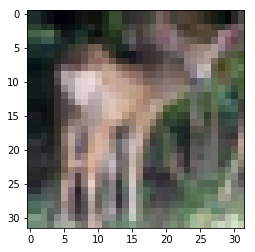

In [10]:
plt.imshow(data.trn_ds.denorm(x)[0]);

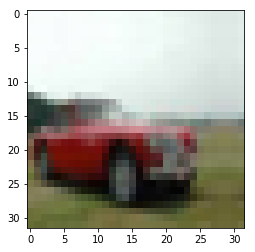

In [11]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [12]:
data = get_data(32,bs)

In [13]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [14]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [15]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [16]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [17]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [18]:
learn.lr_find()

 76%|███████▌  | 148/196 [00:16<00:05,  9.11it/s, loss=7.02]

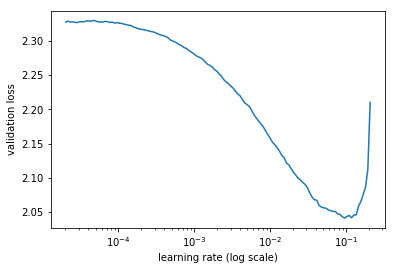

In [19]:
learn.sched.plot()

In [20]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.761237   1.650226   0.4232    
    1      1.665283   1.574091   0.4452                     
CPU times: user 1min 2s, sys: 25.9 s, total: 1min 28s
Wall time: 46.9 s


[array([1.57409]), 0.4452]

In [21]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.615064   1.518554   0.47      
    1      1.587987   1.500069   0.4715                     
CPU times: user 1min 6s, sys: 27 s, total: 1min 33s
Wall time: 49.6 s


[array([1.50007]), 0.4715]

## CNN

In [22]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [23]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [24]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [25]:
learn.lr_find(end_lr=100)

 70%|███████   | 138/196 [00:15<00:06,  8.73it/s, loss=4.87]

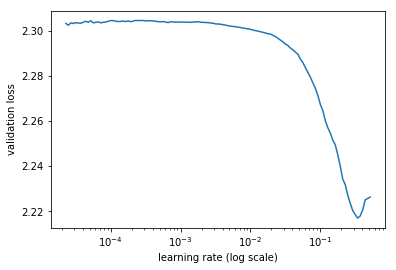

In [26]:
learn.sched.plot()

In [27]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.702843   1.643643   0.3986    
    1      1.524479   1.46196    0.4715                     
CPU times: user 1min 6s, sys: 26.3 s, total: 1min 32s
Wall time: 49.3 s


[array([1.46196]), 0.4715]

In [28]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.334531   1.269016   0.5382    
    1      1.258889   1.207166   0.565                      
    2      1.212779   1.156747   0.5827                     
    3      1.192801   1.125706   0.5934                     
CPU times: user 2min 11s, sys: 54.7 s, total: 3min 5s
Wall time: 1min 39s


[array([1.12571]), 0.5934]

## Refactored

In [29]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [30]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [31]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [32]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [33]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.707955   1.658025   0.3813    
    1      1.54003    1.451503   0.469                      
CPU times: user 1min 4s, sys: 26 s, total: 1min 30s
Wall time: 48.2 s


[array([1.4515]), 0.469]

In [34]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.304428   1.24782    0.5456    
    1      1.25918    1.187788   0.5747                     
CPU times: user 1min 6s, sys: 27 s, total: 1min 33s
Wall time: 49.9 s


[array([1.18779]), 0.5747]

## BatchNorm

In [35]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [36]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [37]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [38]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [39]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.481361   1.31135    0.5285    
    1      1.259284   1.166904   0.5805                     
CPU times: user 1min 7s, sys: 26.4 s, total: 1min 33s
Wall time: 49.3 s


[array([1.1669]), 0.5805]

In [40]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.217902   1.093735   0.6074    
    1      1.080095   0.97502    0.6506                     
    2      1.002      0.925642   0.6734                     
    3      0.944385   0.86117    0.6925                      
CPU times: user 2min 14s, sys: 53.8 s, total: 3min 8s
Wall time: 1min 38s


[array([0.86117]), 0.6925]

## Deep BatchNorm

In [41]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [42]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [43]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.510177   1.346744   0.506     
    1      1.296519   1.171744   0.5798                     
CPU times: user 1min 9s, sys: 26.3 s, total: 1min 36s
Wall time: 50.1 s


[array([1.17174]), 0.5798]

In [44]:
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.099809   1.069968   0.6197    
    1      1.029887   0.96729    0.6485                     
CPU times: user 1min 9s, sys: 26.8 s, total: 1min 36s
Wall time: 50.1 s


[array([0.96729]), 0.6485]

## Resnet

In [45]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [46]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [47]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [48]:
wd=1e-5

In [49]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.547418   1.449797   0.4699    
    1      1.307817   1.234861   0.5558                     
CPU times: user 1min 12s, sys: 27.6 s, total: 1min 40s
Wall time: 53.7 s


[array([1.23486]), 0.5558]

In [50]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.106209   1.033939   0.6316    
    1      1.063236   0.985958   0.6506                     
    2      0.930467   0.89651    0.6811                      
    3      0.978916   0.887345   0.6877                      
    4      0.847763   0.823921   0.7123                      
    5      0.764664   0.746801   0.7373                      
    6      0.72386    0.745375   0.7424                      
CPU times: user 4min 12s, sys: 1min 36s, total: 5min 48s
Wall time: 3min 7s


[array([0.74537]), 0.7424]

In [51]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.82294    0.786206   0.728     
    1      0.74446    0.743319   0.7402                      
    2      0.663985   0.664121   0.7671                      
    3      0.62867    0.663034   0.7658                      
    4      0.722956   0.743931   0.7409                      
    5      0.652886   0.668948   0.7711                      
    6      0.583227   0.619623   0.7852                      
    7      0.551152   0.648686   0.7763                      
    8      0.657281   0.673855   0.7674                      
    9      0.599225   0.648536   0.7801                      
    10     0.523453   0.58634    0.7967                      
    11     0.487793   0.586721   0.8002                      
    12     0.599228   0.649676   0.781                       
    13     0.537842   0.592054   0.7978                      
    14     0.471609   0.595905   0.7978                      
    15     0.444737   0.56

[array([0.52405]), 0.8256]

## Resnet 2

In [52]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [53]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [54]:
wd=1e-6

In [55]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.856777   1.818124   0.407     
    1      1.473902   1.370259   0.5121                     
CPU times: user 1min 13s, sys: 28.6 s, total: 1min 41s
Wall time: 55.4 s


[array([1.37026]), 0.5121]

In [56]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.30243    1.256241   0.5717    
    1      1.237111   1.196897   0.5795                     
    2      1.082192   1.036884   0.6362                     
    3      1.117548   1.023877   0.6353                     
    4      0.994338   0.960271   0.6604                      
    5      0.900853   0.858774   0.6951                      
    6      0.852453   0.857172   0.6973                      
CPU times: user 4min 17s, sys: 1min 38s, total: 5min 56s
Wall time: 3min 13s


[array([0.85717]), 0.6973]

In [57]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.969783   0.933177   0.6737    
    1      0.860559   0.861781   0.694                       
    2      0.775171   0.750869   0.7322                      
    3      0.732423   0.754425   0.7323                      
    4      0.843818   0.835907   0.707                       
    5      0.764953   0.748681   0.7387                      
    6      0.681714   0.710633   0.7491                      
    7      0.648598   0.699278   0.7568                      
    8      0.759297   0.730528   0.7476                      
    9      0.681722   0.694316   0.7523                      
    10     0.617239   0.646396   0.7737                      
    11     0.562324   0.641884   0.7773                      
    12     0.686237   0.742161   0.7406                      
    13     0.626041   0.657576   0.7745                      
    14     0.54785    0.616694   0.7848                      
    15     0.519337   0.61

[array([0.55631]), 0.8154]

In [58]:
learn.save('tmp3')

In [59]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [60]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.502320073234915, 0.8256)

### End